# Frappe dataset

## Import

In [1]:
import pandas as pd
import numpy as np
import os.path

## Load dataset

In [2]:
# open the dataset
left = pd.read_csv('Datasets/frappe dataset/frappe.csv', sep="\t")
right = pd.read_csv('Datasets/frappe dataset/meta.csv', sep="\t")
df = pd.merge(left, right[['item', 'category', 'language']], on=["item"])
df

,user,item,cnt,daytime,weekday,isweekend,homework,cost,weather,country,city,category,language
0,0,0,1,morning,sunday,weekend,unknown,free,sunny,United States,0,Productivity,en
1,9,0,1,morning,sunday,weekend,unknown,free,unknown,unknown,0,Productivity,en
2,181,0,26,noon,sunday,weekend,unknown,free,cloudy,Israel,454,Productivity,en
3,248,0,113,noon,wednesday,workday,unknown,free,cloudy,Peru,799,Productivity,en
4,398,0,7,morning,tuesday,workday,unknown,free,cloudy,South Africa,1083,Productivity,en
...,...,...,...,...,...,...,...,...,...,...,...,...,...
96198,712,4077,7,noon,tuesday,workday,unknown,free,snowy,Latvia,0,Arcade & Action,en
96199,251,4078,2,evening,tuesday,workday,unknown,free,sunny,Saudi Arabia,919,Casual,en
96200,247,4079,1,afternoon,sunday,weekend,unknown,free,unknown,unknown,0,Brain & Puzzle,en
96201,746,4080,6,noon,saturday,weekend,unknown,paid,cloudy,Brazil,102,Productivity,en


## Dataset preprocessing
Context features:
- daytime
- weekday
- isweekend
- weather	

In [3]:
# delete columns that are not needed
del df['homework']
del df['city']
del df['country']

In [4]:
# delete rows where in any column there is a 'unknown' value
df = df[~df.eq('unknown').any(1)]
df = df.reset_index(drop=True)

# make user and items id start from 0
df.user = pd.factorize(df.user)[0]
df.item = pd.factorize(df.item)[0]

print(f'n user: {df.user.nunique()} \t n item: {df.item.nunique()} \t n row: {len(df)}')

# count minimum and max rating
print(f'min rating: {df.cnt.min()} \t max rating: {df.cnt.max()} \t mean rating: {df.cnt.mean()}')

n user: 857 	 n item: 3180 	 n row: 78335
min rating: 1 	 max rating: 21262 	 mean rating: 88.2575732431225


In [5]:
# make rating binary
df['cnt'] = df['cnt'].apply(lambda x: 1 if x > 4 else 0)

#rename rating column
df = df.rename(columns={'cnt': 'rating'})

# merge game categories under a single label 'Games'
game_categories = ['Brain & Puzzle','Arcade & Action','Cards & Casino','Racing','Sports Games','Brain', 'Casual']
book_categories = ['Books & Reference', 'Comics', 'Libraries & Demo']
df.loc[df['category'].isin(game_categories), 'category'] = 'Games'
df.loc[df['category'].isin(book_categories), 'category'] = 'Books'

# binarize language label: 1 if english, 0 otherwise
df['language'] = df['language'].apply(lambda x: 'english' if x == 'en' else 'other')

Text(0, 0.5, 'number of feedback')

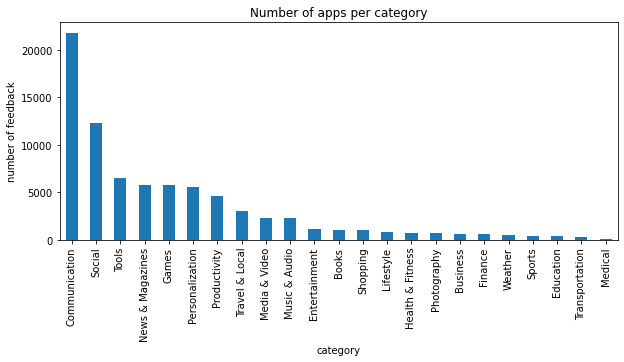

In [8]:
ax = df.category.value_counts().plot.bar(figsize=(10, 4), title='Number of apps per category')
ax.set_xlabel("category")
ax.set_ylabel("number of feedback")

### Add user features
For each user find:
- his favourite app category
- if it uses paid apps
- on which day he used the most applications
- with what weather he used more applications

In [124]:
def get_favourite_feature_by_rating(df, column):
    fav_values = np.zeros((df.user.nunique(), 2), dtype=object)
    for user in df.user.unique():
        # group by column unique values and sum ratings
        grouped = df[['user', column, 'rating']][df.user == user].groupby(['user', column]).sum().sort_values('rating')
        fav_val = grouped.tail(1).index.get_level_values(1).tolist()[0] # get value with highest rating sum
        fav_values[user,:] = [user, fav_val] # add to numpy array of (user, fav_val)
    return pd.DataFrame(fav_values, columns=['user', 'fav_'+column]) # numpy to dataframe

df = pd.merge(df, get_favourite_feature_by_rating(df, 'category'), on=['user'])
df = pd.merge(df, get_favourite_feature_by_rating(df, 'weekday'), on=['user'])
df = pd.merge(df, get_favourite_feature_by_rating(df, 'weather'), on=['user'])
df = pd.merge(df, get_favourite_feature_by_rating(df, 'daytime'), on=['user'])
df = pd.merge(df, get_favourite_feature_by_rating(df, 'isweekend'), on=['user'])
df

,user,item,rating,daytime,weekday,isweekend,cost,weather,category,language,fav_category,fav_weekday,fav_weather,fav_daytime,fav_isweekend
0,0,0,0,morning,sunday,weekend,free,sunny,Productivity,english,Communication,tuesday,sunny,evening,workday
1,0,7,1,evening,friday,weekend,free,cloudy,Travel & Local,english,Communication,tuesday,sunny,evening,workday
2,0,7,0,afternoon,friday,workday,free,cloudy,Travel & Local,english,Communication,tuesday,sunny,evening,workday
3,0,12,0,afternoon,friday,workday,free,cloudy,Social,english,Communication,tuesday,sunny,evening,workday
4,0,14,0,evening,friday,weekend,free,cloudy,Social,english,Communication,tuesday,sunny,evening,workday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78330,852,1598,0,morning,saturday,weekend,paid,cloudy,Communication,english,Communication,saturday,cloudy,morning,weekend
78331,853,1835,1,night,sunday,weekend,paid,sunny,Games,english,Games,sunday,sunny,night,weekend
78332,854,2382,0,morning,tuesday,workday,free,cloudy,Entertainment,english,Entertainment,tuesday,cloudy,morning,workday
78333,855,2508,0,evening,wednesday,workday,free,sunny,Games,english,Games,wednesday,sunny,evening,workday


In [125]:
df.cost = df.cost.eq('paid').mul(1) # convert paid/free to 1/0 
paid_apps = df[['user', 'cost']].groupby(['user'], as_index=False).any() # find if a user runs paid apps
paid_apps = paid_apps.rename(columns={'cost': 'uses_paid_apps'})
df = pd.merge(df, paid_apps, on=['user'])

In [141]:
df.uses_paid_apps.nunique()

2

In [32]:
one_hot = ['daytime', 'weekday', 'isweekend', 'weather', 'category', 'language', 'cost', 'fav_category', 'fav_weekday', 'fav_weather', 'fav_daytime', 'fav_isweekend', 'uses_paid_apps']

# convert categorical data to one-hot encoding
for col in one_hot:
  df = pd.get_dummies(df, columns=[col], prefix = [col])

df

,user,item,rating,daytime_afternoon,daytime_evening,daytime_morning,daytime_night,daytime_noon,daytime_sunrise,daytime_sunset,...,fav_daytime_evening,fav_daytime_morning,fav_daytime_night,fav_daytime_noon,fav_daytime_sunrise,fav_daytime_sunset,fav_isweekend_weekend,fav_isweekend_workday,uses_paid_apps_False,uses_paid_apps_True
0,0,0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,1,1,0
1,0,7,1,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,1,1,0
2,0,7,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,1,0
3,0,12,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,1,0
4,0,14,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78330,852,1598,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,1,0,0,1
78331,853,1835,1,0,0,0,1,0,0,0,...,0,0,1,0,0,0,1,0,0,1
78332,854,2382,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,1,1,0
78333,855,2508,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,1,1,0


In [33]:
df.to_csv('Datasets/frappe dataset/frappe_final.csv', index = False) # save final dataset to CSV

# keep only rating == 1 and drop duplicate to build matrix factorization dataset
df = df[['user', 'item', 'rating']][df.rating == 1]
df = df.drop_duplicates()
# make user and items id start from 0
df.user = pd.factorize(df.user)[0]
df.item = pd.factorize(df.item)[0]
df.to_csv('Datasets/frappe dataset/frappe_matrix_factorization.csv', index = False)